# Feature explanations analysis

In [1]:
import src.feature_importance as feim
from itertools import product
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import dill
from rdkit import Chem
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score

In [2]:
mpl.rcParams.update({'font.size': 12})

In [9]:
with open("./data/pickle/obtained_models_dill.p", "rb") as infile:
    obtained_models = dill.load(infile)

In [8]:
obtained_models

{('P0DMS8',
  0,
  'SVC'): GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.5,
             train_size=None),
              estimator=ExplainingSVC(), n_jobs=1,
              param_grid={'C': [0.1, 1, 10, 50, 100, 200, 400, 500, 750, 1000],
                          'gamma_value': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
              scoring='neg_mean_squared_error')}

In [11]:
with open("./data/pickle/shap_dict.p", "rb") as infile:
    shap_dict = dill.load(infile)
shap_dict

{}

## Loading the data

In [3]:
dataset_df = pd.read_csv("./data/dataset.tsv", sep="\t")

In [4]:
dataset_df.pivot_table(index="uniprot_id", columns="label", values="nonstereo_aromatic_smiles", aggfunc="nunique", fill_value=0)

label,active,random
uniprot_id,,
P0DMS8,287,287


In [5]:
dataset_dict = None
fingerprint_gen_dict = None
shap_dict = None
obtained_models = None
with open("./data/pickle/dataset_dict.p", "rb") as infile:
    dataset_dict = pickle.load(infile)
with open("./data/pickle/fingerprint_gen_dict.p", "rb") as infile:
    fingerprint_gen_dict = pickle.load(infile)
with open("./data/pickle/shap_dict.p", "rb") as infile:
    shap_dict = pickle.load(infile)
with open("./data/pickle/obtained_models.p", "rb") as infile:
    obtained_models = pickle.load(infile)
prediction_df = pd.read_csv("./data/prediction_df.tsv", sep="\t")

In [6]:
obtained_models

{('P0DMS8',
  0,
  'SVC'): GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.5,
             train_size=None),
              estimator=ExplainingSVC(), n_jobs=-1,
              param_grid={'C': [0.1, 1, 10, 50, 100, 200, 400, 500, 750, 1000]},
              scoring='neg_mean_squared_error'),
 ('P0DMS8',
  0,
  'RF'): GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.5,
             train_size=None),
              estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
              param_grid={'min_samples_leaf': [1, 2, 5, 10],
                          'min_samples_split': [2, 3, 5, 7, 10],
                          'n_estimators': [10, 100, 250, 500]},
              scoring='neg_mean_squared_error')}

## Model performances

In [12]:
for data_set_name, dataset_grpd_df in prediction_df.groupby(["dataset_name"]):
    for (algorithm, traininset), split_df in prediction_df.groupby(["algorithm", "trainingset"]):
        split_name = "training set" if traininset else "test set"
        print("{} - {}: {:0.2f}".format(algorithm, split_name, balanced_accuracy_score(split_df.label, split_df.prediction)))

RF - test set: 0.92
RF - training set: 1.00
SVC - test set: 0.50
SVC - training set: 0.50


NameError: name 'obtained_models' is not defined

# Analysis

In [13]:
# Defining assessed target and test-training split
dataset_name = "P0DMS8"
trial = 0

### Setting up variables for analysis

In [14]:
trial_df = prediction_df.query("dataset_name == @dataset_name & trial == @trial")
fingerprint = fingerprint_gen_dict[dataset_name]
dataset = dataset_dict[dataset_name]

svc = obtained_models[(dataset_name, trial, "SVC")].best_estimator_


svc_shapley = shap_dict[(dataset_name, trial, "SVC")]["sverad_values"]
svc_SHAP = shap_dict[(dataset_name, trial, "SVC")]["kernel_shap_values"]
svc_shapley_E = shap_dict[(dataset_name, trial, "SVC")]["expected_value"]
svc_SHAP_E = shap_dict[(dataset_name, trial, "SVC")]["kernel_expected_value"]

rf_shapley = shap_dict[(dataset_name, trial, "RF")]["tree_shap_values"]
rf_SHAP = shap_dict[(dataset_name, trial, "RF")]["kernel_shap_values"]
rf_shapley_E = shap_dict[(dataset_name, trial, "RF")]["expected_value"]
rf_SHAP_E = shap_dict[(dataset_name, trial, "RF")]["kernel_expected_value"]

### Expected values

In [15]:
svc.expected_value

array([-0.13700122])

In [16]:
shap_dict[(dataset_name, trial, "RF")]["expected_value"]

0.49364000000000025

### Predicted log-odds of the SVM

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(data=trial_df.query("testset").query("algorithm == 'SVC'"), x="log_odds", hue="label", ax=ax, common_norm=False)
sns.histplot(data=trial_df.query("testset").query("algorithm == 'SVC'"), x="log_odds", hue="label", ax=ax, common_norm=False, stat="density")
plt.savefig(f"./figures/{dataset_name}/predicted_log_odds.png", dpi=300)

KeyboardInterrupt: 

## Absence and presence of features

### Defining assessed compounds and transforming the dataframe for analysis

In [14]:
correct_predicted_df = trial_df.query("label == prediction & testset")

In [15]:
correct_predicted_df_molten = correct_predicted_df.melt(id_vars=["nonstereo_aromatic_smiles", "dataset_idx", "label", "algorithm"],
                                                        value_vars=["present_shap", "absent_shap", "kernel_present_shap", "kernel_absent_shap"],
                                                        value_name="Shapley sum")

In [16]:
# Renaming the columns from 0 and 1 to random and active, respectively.
correct_predicted_df_molten["label_str"] = "Random"
correct_predicted_df_molten.loc[correct_predicted_df_molten["label"] == 1, "label_str"] = "Active"

correct_predicted_df_molten["variable_str"] = ""
correct_predicted_df_molten.loc[correct_predicted_df_molten.variable == "present_shap", "variable_str"] = "Present features"
correct_predicted_df_molten.loc[correct_predicted_df_molten.variable == "absent_shap", "variable_str"] = "Absent features"

### SVs for SVM using SVERAD

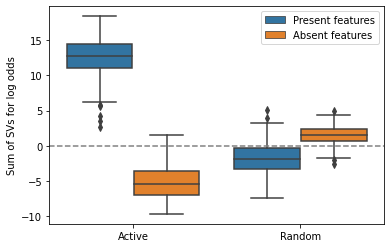

In [17]:
fig, ax = plt.subplots()
sns.boxplot(data=correct_predicted_df_molten.query("algorithm == 'SVC'"), x="label_str", hue="variable_str", y="Shapley sum", hue_order=["Present features", "Absent features"])
xlim = ax.get_xlim()
ax.hlines(0, *xlim, color="gray", ls="--")
ax.set_xlim(xlim)
ax.set_xlabel("")
ax.set_ylabel(r"Sum of SVs for log odds")
ax.legend(*ax.get_legend_handles_labels())
plt.savefig(f"./figures/{dataset_name}/boxplot_present_absent_shap_svc_exact.png", dpi=300)

#### Contributions of all features of random compounds.

In [18]:
correct_predicted_df.query("algorithm == 'SVC' & label == 0")[["present_shap", "absent_shap"]].sum(axis=1).mean()

-0.37688715703230696

In [19]:
correct_predicted_df.query("algorithm == 'SVC' & label == 0")[["present_shap", "absent_shap"]].sum(axis=1).std()

0.9379608858155831

### Kernel-SHAP of SVM
Not part of publication.

(-0.5, 1.5)

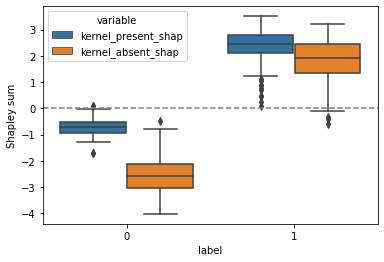

In [20]:
fig, ax = plt.subplots()
sns.boxplot(data=correct_predicted_df_molten.query("algorithm == 'SVC'"), x="label", hue="variable", y="Shapley sum", hue_order=["kernel_present_shap", "kernel_absent_shap"])
xlim = ax.get_xlim()
ax.hlines(0, *xlim, color="gray", ls="--")
ax.set_xlim(xlim)
#plt.savefig(f"./figures/{dataset_name}/boxplot_present_absent_shap_svc_shap.png")

### SVs for RF using TreeExplainer

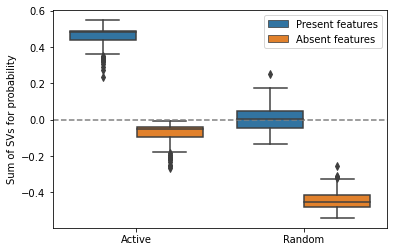

In [21]:
fig, ax = plt.subplots()
sns.boxplot(data=correct_predicted_df_molten.query("algorithm == 'RF'"), x="label_str", hue="variable_str", y="Shapley sum", hue_order=["Present features", "Absent features"])
xlim = ax.get_xlim()
ax.hlines(0, *xlim, color="gray", ls="--")
ax.set_xlim(xlim)
ax.set_xlabel("")
ax.set_ylabel(r"Sum of SVs for probability")
ax.legend(*ax.get_legend_handles_labels())
plt.savefig(f"./figures/{dataset_name}/boxplot_present_absent_shap_rf_exact.png", dpi=300)

### Kernel-SHAP of RF

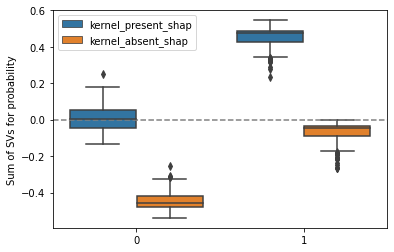

In [22]:
fig, ax = plt.subplots()
sns.boxplot(data=correct_predicted_df_molten.query("algorithm == 'RF'"), x="label", hue="variable", y="Shapley sum", hue_order=["kernel_present_shap", "kernel_absent_shap"])
xlim = ax.get_xlim()
ax.hlines(0, *xlim, color="gray", ls="--")
ax.set_xlim(xlim)
ax.set_xlabel("")
ax.set_ylabel(r"Sum of SVs for probability")
ax.legend(*ax.get_legend_handles_labels())
#plt.savefig(f"./figures/{dataset_name}/boxplot_present_absent_shap_rf_shap.png")

## Correlation between models and explanations

In [23]:
correlation_df = []
all_contributions = [("SVs SVM", svc_shapley),
                     ("SHAP values SVM", svc_SHAP),
                     ("SVs RF", rf_shapley),
                     ("SHAP values RF", rf_SHAP),
                    ]
for i, row in trial_df.query("algorithm == 'SVC'").iterrows():
    for (alg1, values1), (alg2, values2) in product(all_contributions, repeat=2):
        corr, p = pearsonr(values1[row["dataset_idx"]], values2[row["dataset_idx"]])
        correlation_df.append({"algorithm1": alg1,
                               "algorithm2": alg2,
                               "nonstereo_aromatic_smiles": row["nonstereo_aromatic_smiles"],
                               "label": row["label"],
                               "dataset_idx": row["dataset_idx"],
                               "trainingset": row["trainingset"],

                               "corrleation": corr,
                              })
correlation_df = pd.DataFrame(correlation_df)
correlation_df["pearsons_r_fisher"] = np.arctanh(correlation_df.corrleation)
correlation_df["datasetlabel"] = "Testset"
correlation_df.loc[correlation_df["trainingset"], "datasetlabel"] = "Trainingset"

/home/bob/anaconda3/envs/sveta/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


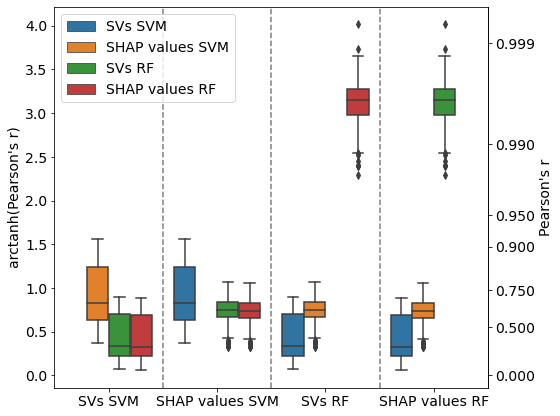

In [24]:
mpl.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=correlation_df.query("algorithm1 != algorithm2 & datasetlabel == 'Testset'"), x="algorithm1", y="pearsons_r_fisher", hue="algorithm2", hue_order=["SVs SVM", "SHAP values SVM", "SVs RF", "SHAP values RF"])
ylim= ax.get_ylim()
ax.vlines(0.5, *ylim, color="gray", ls="--")
ax.vlines(1.5, *ylim, color="gray", ls="--")
ax.vlines(2.5, *ylim, color="gray", ls="--")
ax.set_ylim(*ylim)
ax.set_xlim(-0.5, 3.5)
ax.set_ylabel("arctanh(Pearson's r)")
secax = ax.secondary_yaxis('right', functions=(np.tanh, np.arctanh))
secax.set_ylabel("Pearson's r")
secax.set_yticks([-0.5, 0, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]);
ax.set_xlabel("")
ax.legend(*ax.get_legend_handles_labels())
plt.tight_layout()
plt.savefig(f"./figures/{dataset_name}/correlation_model_explanations.png", dpi=300)
mpl.rcParams.update({'font.size': 12})

In [25]:
correlation_df.query("algorithm1 != algorithm2 & datasetlabel == 'Testset'").pivot_table(index="algorithm1", columns="algorithm2", values="pearsons_r_fisher", aggfunc="median").apply(np.tanh)

algorithm2,SHAP values RF,SHAP values SVM,SVs RF,SVs SVM
algorithm1,,,,
SHAP values RF,NaN,0.630129,0.996317,0.316455
SHAP values SVM,0.630129,NaN,0.634462,0.681617
SVs RF,0.996317,0.634462,NaN,0.323621
SVs SVM,0.316455,0.681617,0.323621,NaN


## Mapping of present features
### Selecting the first compound

In [26]:
vis_cpd_idx = 160
vis_cpd_smiles = dataset.nonstereo_aromatic_smiles[vis_cpd_idx]
trial_df.query("nonstereo_aromatic_smiles == @vis_cpd_smiles")

,nonstereo_aromatic_smiles,dataset_idx,label,prediction,log_odds,proba,trainingset,testset,trial,dataset_name,algorithm,present_shap,absent_shap,kernel_present_shap,kernel_absent_shap
160,CNC(=O)C1OC(n2cnc3c(NOC)nc(C#Cc4ccccc4)nc32)C(...,160,1,1,6.494686,0.998491,False,True,0,P0DMS8,SVC,17.878118,-8.844905,3.419947,2.742589
734,CNC(=O)C1OC(n2cnc3c(NOC)nc(C#Cc4ccccc4)nc32)C(...,160,1,1,NaN,1.000000,False,True,0,P0DMS8,RF,0.502489,-0.059568,0.493541,-0.050620


### SVM explanation

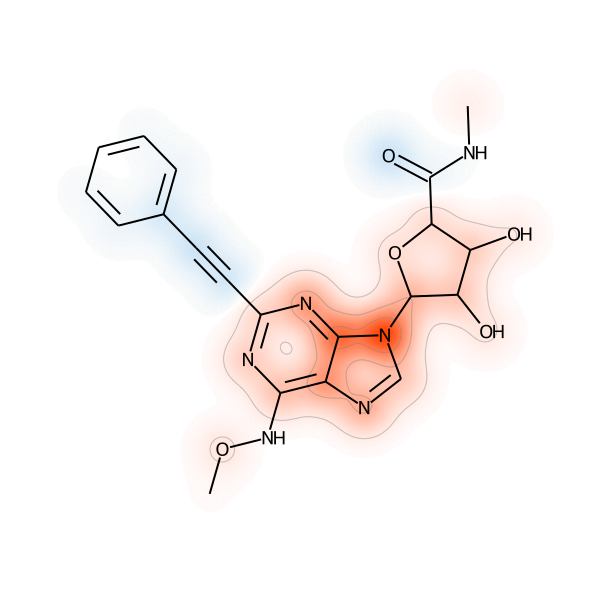

In [27]:
# Creating a RDKit mol object
vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
# Determining SVs of present features (absent features cannot be mapped, as they are ... absent)
svr_present_shap = svc_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
# Mapping SVs to atoms
atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
# Generating the figure.
svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
fig = feim.show_png(svg_image.GetDrawingText())
fig.save(f"./figures/{dataset_name}/shap_mapping/{vis_cpd_idx}_{vis_cpd_smiles}_svc.png")
display(fig)

### RF explanation

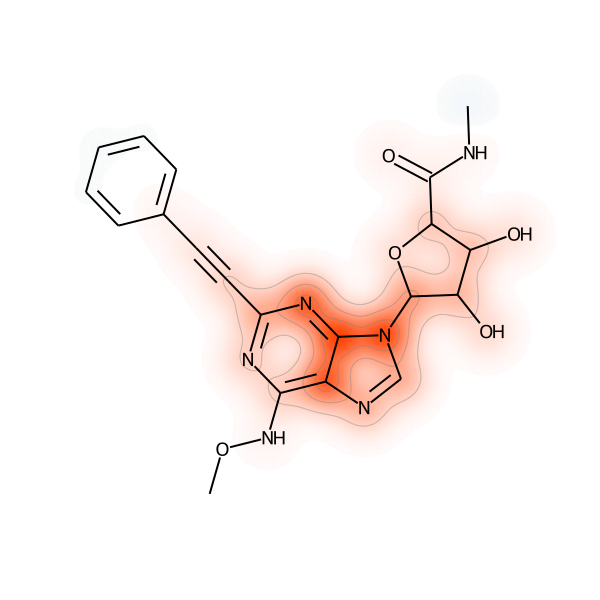

In [28]:
vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
svr_present_shap = rf_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
fig = feim.show_png(svg_image.GetDrawingText())
fig.save(f"./figures/{dataset_name}/shap_mapping/{vis_cpd_idx}_{vis_cpd_smiles}_rf.png")
display(fig)

In [29]:
### Selecting the second CPD

In [30]:
vis_cpd_idx = 75
vis_cpd_smiles = dataset.nonstereo_aromatic_smiles[vis_cpd_idx]
trial_df.query("nonstereo_aromatic_smiles == @vis_cpd_smiles")

,nonstereo_aromatic_smiles,dataset_idx,label,prediction,log_odds,proba,trainingset,testset,trial,dataset_name,algorithm,present_shap,absent_shap,kernel_present_shap,kernel_absent_shap
75,CCCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc2...,75,1,1,6.398065,0.998338,False,True,0,P0DMS8,SVC,16.726376,-7.789783,2.836945,3.228971
649,CCCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc2...,75,1,1,NaN,1.000000,False,True,0,P0DMS8,RF,0.487987,-0.045065,0.481813,-0.038891


### SVM explanation

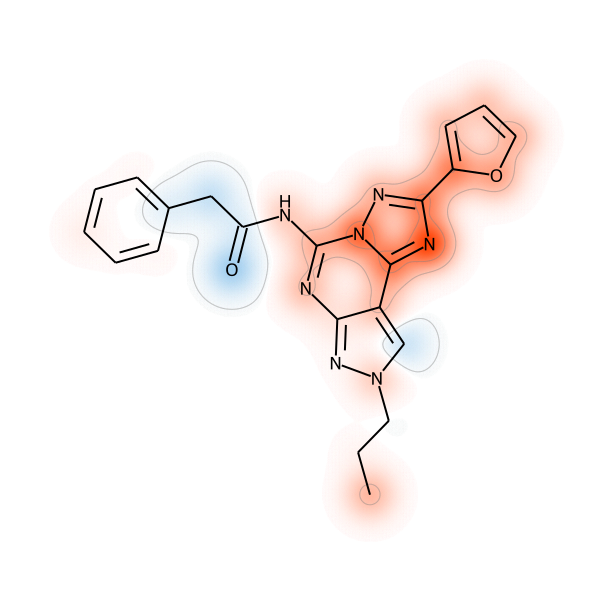

In [32]:
trial_df.query("nonstereo_aromatic_smiles == @vis_cpd_smiles")
vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
svr_present_shap = svc_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
fig = feim.show_png(svg_image.GetDrawingText())
fig.save(f"./figures/{dataset_name}/shap_mapping/{vis_cpd_idx}_{vis_cpd_smiles}_svc.png")
display(fig)

### RF explanation

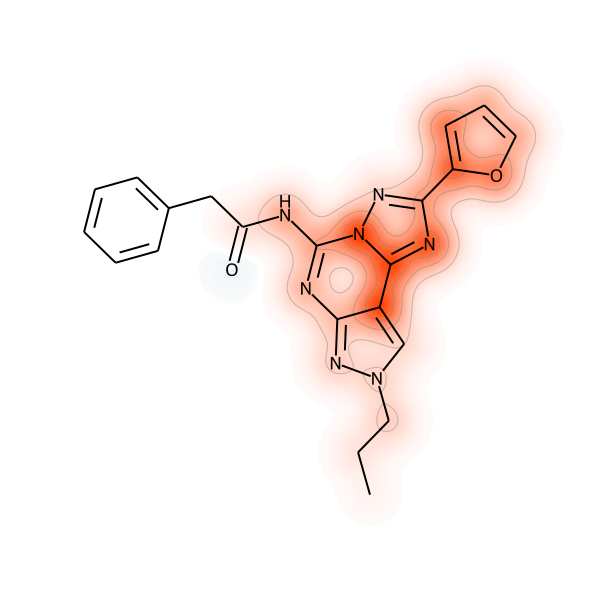

In [34]:
vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
svr_present_shap = rf_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
fig = feim.show_png(svg_image.GetDrawingText())
fig.save(f"./figures/{dataset_name}/shap_mapping/{vis_cpd_idx}_{vis_cpd_smiles}_rf.png")
display(fig)